# Big data and ML - Hands-on Day 1

- course [slides](https://github.com/Course-bigDataAndML/MLCourse-INFN-2022/blob/main/Slides/Day1/Big%20data%20science%20-%20Day%201%20-%20INFN%202022.pdf)

## You'll learn

- familiarize with jupyter notebooks, numpy and pandas

### Input data
- efficient data format: convert CSV to Parquet
- create input vector with features for MLLib. Format of the input depends on chosen ML library

### Visualization
- explore dataset, plot features
- correlation matrix


## Dataset description

The dataset used in this example is described [here](https://archive.ics.uci.edu/ml/datasets/HIGGS). It is a binary classification problem where the goal is to train a classifier able to distinguish between a signal process, the production of new theoretical Higgs bosons, and a background process with identical decay products but distinct kinematic features.

Each row of this dataset contains 28 features plus the label:

- 21 low-level features which represent the basic measure made by the particle detector
 -        Momentum of the observed paricles
 -        Missing transverse momentum
 -        Jets and b-tagging information
- 7 high-level features computed from the low-level features that encode the knowledge of the different intermediate states of the two processes (reconstructed invariant masses)

# Setup the environment

Execute this cell only the first time you run the notebook. It will install necessary packages for your code to run

In [ ]:
#!pip install pandas seaborn pyarrow fastparquet sklearn tensorflow 
#!pip install liboidcagent requests xmltodict boto3

In [ ]:
!pip install liboidcagent requests xmltodict boto3 numpy

Import necessary packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# our custom functions
from custom_functions import *

#### Remember to start spark by clicking on the square icon all the way to the right

Setup and restart the Spark context with our configuration

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# get token to authenticate to minio storage
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

# build Spark configuration options    
conf = setupSpark(token)

# to update Spark config, we need first to stop the spark context
SparkContext.stop(sc)

# Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# check if Spark is there
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

In [3]:
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

# Exercise 1

## Input files - local read

- Create parquet files, which are faster to read than CSV
- Read [here](https://operational-intelligence.web.cern.ch/DataFormats) for a description of the most common data formats and their use

In [4]:
!ls

custom_functions.py  inputForML.ipynb		 install.sh
Higgs100k.csv	     inputForML_solutions.ipynb  __pycache__


In [9]:
pd.read_csv('Higgs100k.csv')

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_b-tag,...,je4_eta,jet4_phi,jet4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.0,0.874600,0.665167,-1.657614,1.238662,-1.409092,0.964624,0.169304,0.804559,0.000000,...,-0.606756,-0.863710,3.101961,0.924886,0.897148,0.986477,1.054752,0.292659,0.784287,0.969133
99995,0.0,1.541120,-0.948700,-0.762068,0.752259,-0.835360,0.554040,-0.258475,0.639910,1.086538,...,0.111138,0.049226,0.000000,0.359801,0.921513,0.977563,1.157282,0.971256,0.962689,0.914845
99996,1.0,0.957321,-0.759750,1.210569,0.863929,-0.120751,0.505580,0.058398,-0.496662,1.086538,...,1.127182,1.674563,0.000000,0.838526,0.731589,1.173853,0.848387,0.840251,0.702825,0.642653
99997,1.0,0.878993,-1.687942,-1.318039,0.407732,-1.481964,0.847367,-0.680313,1.462603,1.086538,...,-1.756052,-0.869814,0.000000,0.841216,1.112265,1.003257,0.768167,0.911731,0.911673,0.805071


In [5]:
#read local CSV into a panda dataframe
%time dataset = pd.read_csv('Higgs100k.csv')

CPU times: user 1.13 s, sys: 352 ms, total: 1.48 s
Wall time: 2.94 s


In [6]:
#remove old parquet file
!rm -rf Higgs100k.parquet

dataset.to_parquet('Higgs100k.parquet')

### Now read it back

- check that you indeed created the parquet file (ls)!
- read in the parquet file you just created (Hint: the syntax is very similar to the one above for the csv file)
- how much faster is to read parquet files rather than csv?

In [7]:
!ls

custom_functions.py  Higgs100k.parquet	inputForML_solutions.ipynb  __pycache__
Higgs100k.csv	     inputForML.ipynb	install.sh


In [8]:
pd.read_parquet('Higgs100k.parquet')

,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_b-tag,...,je4_eta,jet4_phi,jet4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.0,0.874600,0.665167,-1.657614,1.238662,-1.409092,0.964624,0.169304,0.804559,0.000000,...,-0.606756,-0.863710,3.101961,0.924886,0.897148,0.986477,1.054752,0.292659,0.784287,0.969133
99995,0.0,1.541120,-0.948700,-0.762068,0.752259,-0.835360,0.554040,-0.258475,0.639910,1.086538,...,0.111138,0.049226,0.000000,0.359801,0.921513,0.977563,1.157282,0.971256,0.962689,0.914845
99996,1.0,0.957321,-0.759750,1.210569,0.863929,-0.120751,0.505580,0.058398,-0.496662,1.086538,...,1.127182,1.674563,0.000000,0.838526,0.731589,1.173853,0.848387,0.840251,0.702825,0.642653
99997,1.0,0.878993,-1.687942,-1.318039,0.407732,-1.481964,0.847367,-0.680313,1.462603,1.086538,...,-1.756052,-0.869814,0.000000,0.841216,1.112265,1.003257,0.768167,0.911731,0.911673,0.805071


In [10]:
%time pd.read_parquet('Higgs100k.parquet')

CPU times: user 70.3 ms, sys: 85.8 ms, total: 156 ms
Wall time: 67.6 ms


,label,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_b-tag,...,je4_eta,jet4_phi,jet4_b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.0,0.874600,0.665167,-1.657614,1.238662,-1.409092,0.964624,0.169304,0.804559,0.000000,...,-0.606756,-0.863710,3.101961,0.924886,0.897148,0.986477,1.054752,0.292659,0.784287,0.969133
99995,0.0,1.541120,-0.948700,-0.762068,0.752259,-0.835360,0.554040,-0.258475,0.639910,1.086538,...,0.111138,0.049226,0.000000,0.359801,0.921513,0.977563,1.157282,0.971256,0.962689,0.914845
99996,1.0,0.957321,-0.759750,1.210569,0.863929,-0.120751,0.505580,0.058398,-0.496662,1.086538,...,1.127182,1.674563,0.000000,0.838526,0.731589,1.173853,0.848387,0.840251,0.702825,0.642653
99997,1.0,0.878993,-1.687942,-1.318039,0.407732,-1.481964,0.847367,-0.680313,1.462603,1.086538,...,-1.756052,-0.869814,0.000000,0.841216,1.112265,1.003257,0.768167,0.911731,0.911673,0.805071


## Data from s3 object storage

- A much bigger dataset is available on the S3 object store
- Use the smallest dataset for code development
- Once your code is ready, you can try it on more events. Be aware of memory consumption and execution time!

In [11]:
#inputFile = "s3a://scratch/legger/higgs/Higgs1M.parquet"
inputFile = "s3a://scratch/legger/higgs/Higgs100k.parquet"

%time df_1M = spark.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 9.82 ms, sys: 4.53 ms, total: 14.4 ms
Wall time: 9.79 s


In [12]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(df_1M.rdd.getNumPartitions()))
print("Partitioner: {}".format(df_1M.rdd.partitioner))

Number of partitions: 3
Partitioner: None


## Explore the input dataset

Let's have a look at the input data. First we create a spark dataframe called *df*.

In [13]:
df = spark.createDataFrame(dataset)

%time total_events = df.count()

print('There are '+str(total_events)+' events')

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 4.33 s
There are 99999 events


In [14]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

# Exercise 2

- plot a few input variables and try to understand which ones are more promising to distinguish signal from background  

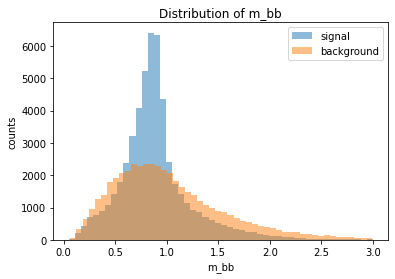

In [15]:
#plot invariant mass distribution 
plotSignalvsBg(df, 'm_bb')

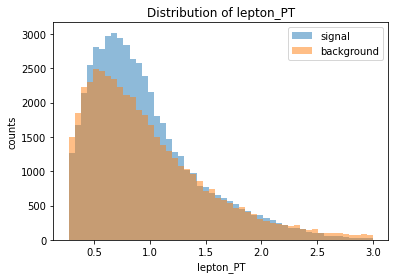

In [16]:
plotSignalvsBg(df,'lepton_PT')

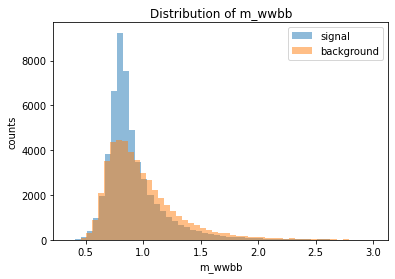

In [17]:
plotSignalvsBg(df,'m_wwbb')

# Exercise 3

#### Create the input feature vector

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe *df* a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer
- Eventually the dataframe should have the following variables:

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, **features: vector**]

In [18]:
df

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double]

In [19]:
from pyspark.ml.linalg import Vectors

In [20]:
from pyspark.ml.feature import VectorAssembler

In [23]:
assembler = VectorAssembler(inputCols=["lepton_pT", "lepton_eta", "lepton_phi", "missing_energy_magnitude", "missing_energy_phi", "jet1_pt", "jet1_eta", "jet1_phi", "jet1_b-tag", "jet2_pt", "jet2_eta", "jet2_phi", "jet2_b-tag", "jet3_pt", "jet3_eta", "jet3_phi", "jet3_b-tag", "jet4_pt", "je4_eta", "jet4_phi", "jet4_b-tag", "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"], outputCol="features")

In [24]:
output = assembler.transform(df)

In [25]:
#output.select("features", "m_wwbb").show(truncate=False)
df

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double]

In [26]:
output

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

In [28]:
output.select("features", "m_wwbb").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                           